In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from math import sqrt
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from joblib import load  # Make sure to import joblib for loading the scalers
import os

In [25]:
data_for_lstm = pd.read_csv("modeling_data_2.csv")

In [26]:
data_for_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20431 entries, 0 to 20430
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   County_2                   20431 non-null  int64  
 1   Date                       20431 non-null  object 
 2   Year                       20431 non-null  float64
 3   Year_sin                   20431 non-null  float64
 4   Year_cos                   20431 non-null  float64
 5   Wholesale_lag_7            20431 non-null  float64
 6   Retail_lag_7               20431 non-null  float64
 7   Wholesale_rolling_mean_7d  20431 non-null  float64
 8   Retail_rolling_mean_7d     20431 non-null  float64
 9   Wholesale_rolling_std_7d   20431 non-null  float64
 10  Retail_rolling_std_7d      20431 non-null  float64
 11  Wholesale                  20431 non-null  float64
 12  Retail                     20431 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usa

In [27]:
data_for_lstm.isna().sum()

County_2                     0
Date                         0
Year                         0
Year_sin                     0
Year_cos                     0
Wholesale_lag_7              0
Retail_lag_7                 0
Wholesale_rolling_mean_7d    0
Retail_rolling_mean_7d       0
Wholesale_rolling_std_7d     0
Retail_rolling_std_7d        0
Wholesale                    0
Retail                       0
dtype: int64

In [28]:
data_for_lstm = data_for_lstm.dropna()

In [29]:
data_for_lstm = data_for_lstm.drop(columns=['Date'])

In [30]:
# Define target variable - using Wholesale
target = data_for_lstm['Wholesale']
target2 = data_for_lstm['Retail']

# Define features - excluding target variable
features = data_for_lstm.drop(columns=['Wholesale','Retail'])

# Splitting the data into train and test sets while maintaining temporal order
train_size = int(len(features) * 0.7)
validation_size = int(len(features) * 0.15)
test_size = len(features) - train_size - validation_size

train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

validation_features, test_features = test_features[:validation_size], test_features[validation_size:]
validation_target, test_target = test_target[:validation_size], test_target[validation_size:]

# Verifying the sizes of each set
(train_features.shape, validation_features.shape, test_features.shape), (train_target.shape, validation_target.shape, test_target.shape)

(((14301, 10), (3064, 10), (3066, 10)), ((14301,), (3064,), (3066,)))

In [31]:
# Reshaping input data for LSTM [samples, time steps, features]
# Assuming a time step of 1 for simplicity in this initial model
train_X = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
validation_X = validation_features.values.reshape((validation_features.shape[0], 1, validation_features.shape[1]))
test_X = test_features.values.reshape((test_features.shape[0], 1, test_features.shape[1]))

In [32]:
# Initial LSTM Model
model = Sequential()
model.add(LSTM(30, activation='tanh', input_shape=(1, train_features.shape[1])))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model
model.summary()

# Training the model
history = model.fit(train_X, train_target, epochs=10, batch_size=32, validation_data=(validation_X, validation_target), verbose=2)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30)                4920      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,951
Trainable params: 4,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
447/447 - 9s - loss: 8.7007e-04 - val_loss: 0.0014 - 9s/epoch - 19ms/step
Epoch 2/10
447/447 - 2s - loss: 6.0306e-04 - val_loss: 0.0013 - 2s/epoch - 4ms/step
Epoch 3/10
447/447 - 2s - loss: 5.8139e-04 - val_loss: 0.0013 - 2s/epoch - 5ms/step
Epoch 4/10
447/447 - 2s - loss: 5.7244e-04 - val_loss: 0.0013 - 2s/epoch - 5ms/step
Epoch 5/10
447/447 - 2s - loss: 5.6622e-04 - val_loss: 0.0013 - 2s/epoch - 4ms/step
Epoch 6/10
447/447 - 1s - l

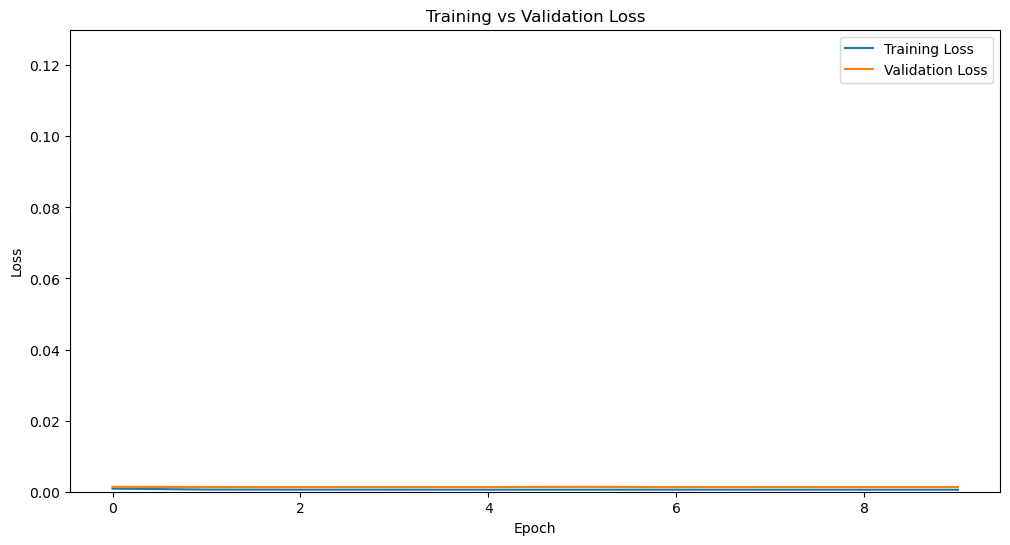

In [33]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 0.130])
plt.legend(loc='upper right')
plt.show()

In [34]:
# Predicting on the test set
test_predictions = model.predict(test_X)

# RMSE (Root Mean Squared Error)
mse_metric = MeanSquaredError()
mse_metric.update_state(test_target, test_predictions)
rmse = sqrt(mse_metric.result().numpy())

# MAE (Mean Absolute Error)
mae_metric = MeanAbsoluteError()
mae_metric.update_state(test_target, test_predictions)
mae = mae_metric.result().numpy()

# MAPE (Mean Absolute Percentage Error)
mape_metric = MeanAbsolutePercentageError()
mape_metric.update_state(test_target, test_predictions)
mape = mape_metric.result().numpy()

rmse, mae, mape

96/96 [==============================] - 1s 3ms/step


(0.030703074322360198, 0.010686745, 46254.953)

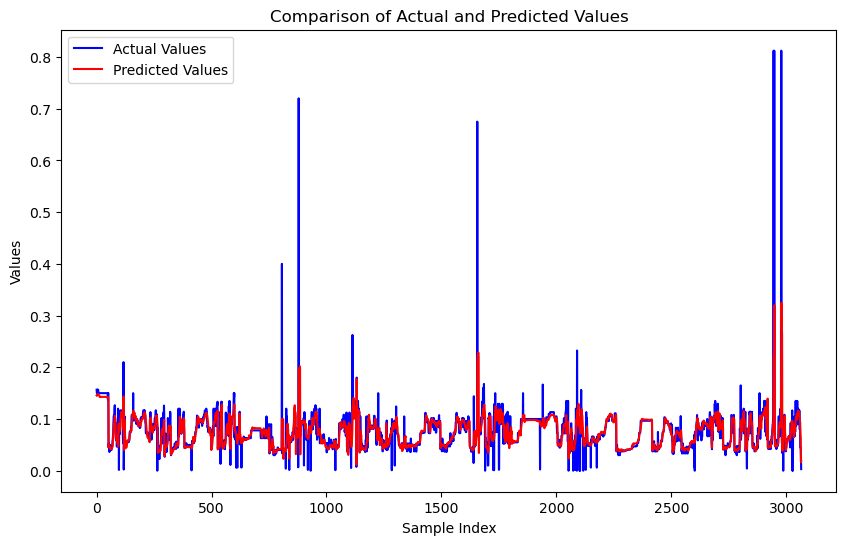

In [35]:
# Converting predictions and actual values to a compatible format for plotting
# Convert the Pandas Series to NumPy array before flattening
actual = np.array(test_target).flatten()
predicted = np.array(test_predictions).flatten()

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Values', color='blue')
plt.plot(predicted, label='Predicted Values', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## Tuning

In [36]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.optimizers import Adam
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Model-building function
# def create_model(units=50, activation='tanh', optimizer='Adam', dropout_rate=0.1):
#     model = Sequential()
#     model.add(LSTM(units=units, activation=activation, input_shape=(train_features.shape[1], 1)))  # Adjust the input shape
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1))  # Predicting only Wholesale prices
#     if optimizer == 'Adam':
#         optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# # Wrap the model with KerasRegressor
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define the hyperparameters grid to search
# param_grid = {
#     'units': [10,20,30,40,50],
#     'activation': ['relu', 'tanh', 'sigmoid'],
#     'optimizer': ['Adam', 'RMSprop'],
#     'dropout_rate': [0.1, 0.2, 0.3],
#     'epochs': [5,6,7,10,15,20],  
#     'batch_size': [8, 16, 32, 64, 128]  
# }

# # Reshape train_features for LSTM (samples, time steps, features)
# train_features_reshaped = train_features.values.reshape((train_features.shape[0], train_features.shape[1], 1))

# # Set up RandomizedSearchCV with a large n_iter to approximate a full grid search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=3, random_state=42)

# # Fit RandomizedSearchCV
# train_target = train_target.ravel()  
# random_search.fit(train_features_reshaped, train_target)

# # Get the best parameters and the best model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_
# (best_params, best_model)


In [37]:
from functions import *

In [38]:
def create_model():
    model = Sequential()
    # Assuming train_X is your feature data
    model.add(LSTM(units=50, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))  # Adjust input shape
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Predicting Wholesale prices
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [39]:
# Instantiate the model
model = create_model()

# Summary of the model 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Train the model with the grid search parameters
history = model.fit(train_X, train_target, 
                    epochs=20,             # Number of epochs set to 20
                    batch_size=64,          # Batch size of 64
                    validation_data=(validation_X, validation_target), 
                    verbose=2)              # Verbose set to 2 for detailed output

Epoch 1/20
224/224 - 9s - loss: 0.0013 - val_loss: 0.0015 - 9s/epoch - 42ms/step
Epoch 2/20
224/224 - 1s - loss: 7.6246e-04 - val_loss: 0.0014 - 935ms/epoch - 4ms/step
Epoch 3/20
224/224 - 1s - loss: 6.9465e-04 - val_loss: 0.0013 - 1s/epoch - 5ms/step
Epoch 4/20
224/224 - 2s - loss: 6.4077e-04 - val_loss: 0.0013 - 2s/epoch - 7ms/step
Epoch 5/20
224/224 - 1s - loss: 6.2019e-04 - val_loss: 0.0013 - 1s/epoch - 5ms/step
Epoch 6/20
224/224 - 1s - loss: 6.0725e-04 - val_loss: 0.0013 - 931ms/epoch - 4ms/step
Epoch 7/20
224/224 - 1s - loss: 6.0386e-04 - val_loss: 0.0013 - 787ms/epoch - 4ms/step
Epoch 8/20
224/224 - 1s - loss: 5.8973e-04 - val_loss: 0.0013 - 1s/epoch - 5ms/step
Epoch 9/20
224/224 - 2s - loss: 5.7920e-04 - val_loss: 0.0013 - 2s/epoch - 9ms/step
Epoch 10/20
224/224 - 1s - loss: 5.7930e-04 - val_loss: 0.0013 - 1s/epoch - 6ms/step
Epoch 11/20
224/224 - 1s - loss: 5.7637e-04 - val_loss: 0.0013 - 999ms/epoch - 4ms/step
Epoch 12/20
224/224 - 1s - loss: 5.7003e-04 - val_loss: 0.0013 - 

In [41]:
test_predictions = model.predict(test_X)


96/96 [==============================] - 1s 2ms/step


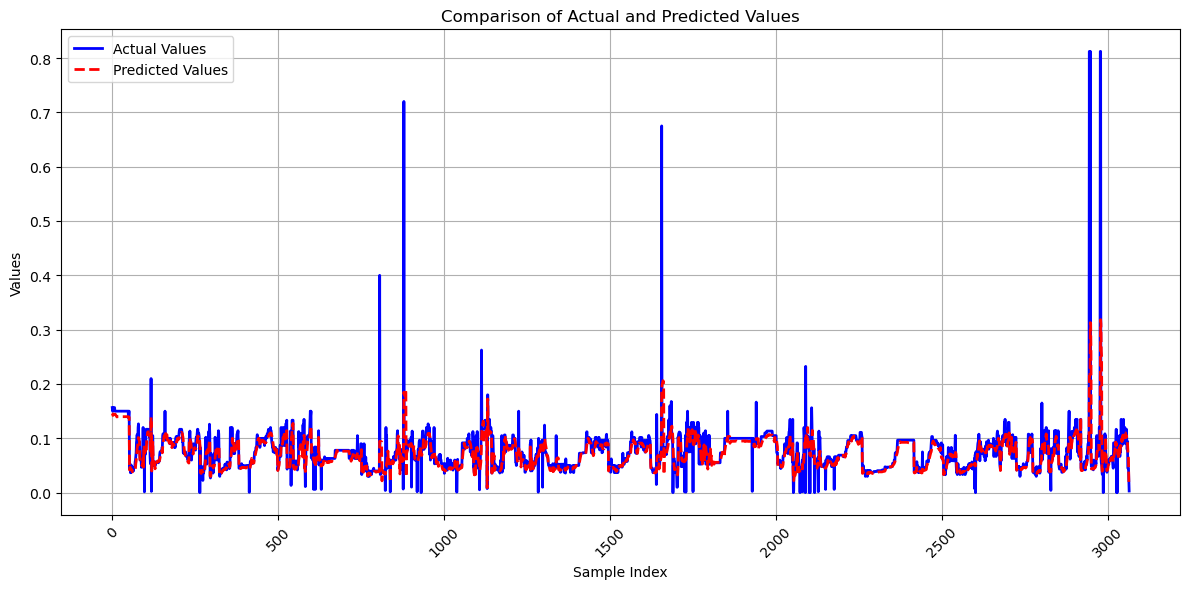

In [42]:
# Flatten the arrays to ensure they are 1D
actual = np.array(test_target).flatten()  # Flattening the actual values
predicted = np.array(test_predictions).flatten()  # Flattening the predicted values

# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Values', color='blue', linestyle='-', linewidth=2)
plt.plot(predicted, label='Predicted Values', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [43]:
# Load the scalers from the file
scaler_file_path = 'models/scalers.pkl'
scalers = load(scaler_file_path)

# Assuming `test_predictions` is your array of predicted values for the "Wholesale" column
# Convert test_predictions to a DataFrame for inverse transformation
predicted_wholesale_scaled = np.array(test_predictions).reshape(-1, 1)  # Reshape if it's a 1D array

# Use the scaler for the "Wholesale" column to inverse the transformation
wholesale_scaler = scalers['Wholesale']
predicted_wholesale = wholesale_scaler.inverse_transform(predicted_wholesale_scaled)

# Flatten the predicted values back to 1D if needed
predicted_wholesale = predicted_wholesale.flatten()

# Display the first few values of the unscaled predicted wholesale prices
print(predicted_wholesale[:10])  # Show first 10 values

[95.17458  95.74448  94.75215  96.71733  95.975266 95.975266 95.975266
 95.975266 96.30446  96.30446 ]


In [44]:
# Evaluate the model on test data
test_loss = model.evaluate(test_X, test_target)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = model.predict(test_X)

# Compare predictions with actual values
print("Predicted Prices:", y_pred[:5])
print("Actual Prices:", test_target[:5])


96/96 [==============================] - 0s 2ms/step - loss: 9.4956e-04
Test Loss: 0.0009495579288341105
96/96 [==============================] - 0s 2ms/step
Predicted Prices: [[0.1427483 ]
 [0.14360315]
 [0.14211464]
 [0.14506245]
 [0.14394933]]
Actual Prices: 17365    0.156647
17366    0.149986
17367    0.149986
17368    0.156647
17369    0.156647
Name: Wholesale, dtype: float64
